In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

from ketsu.utils.cli import BaseMLCLI, BaseMLArgs
from ketsu.datasets import ConjDataset

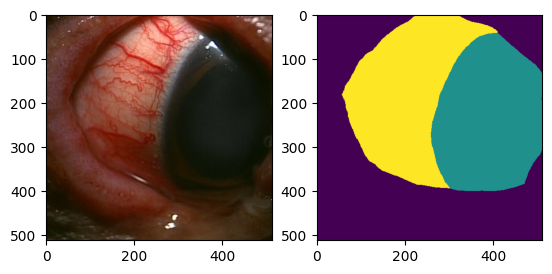

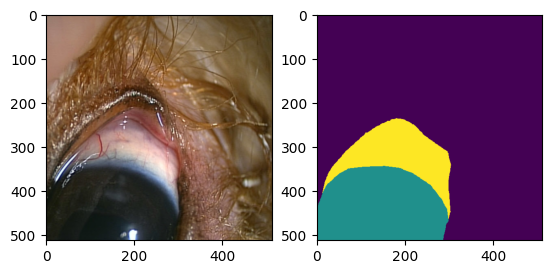

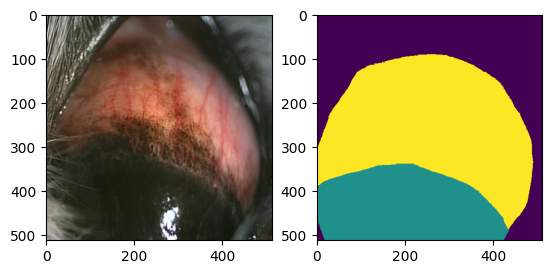

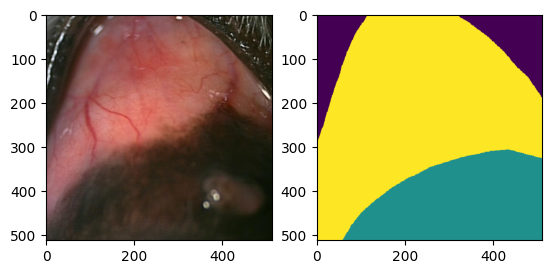

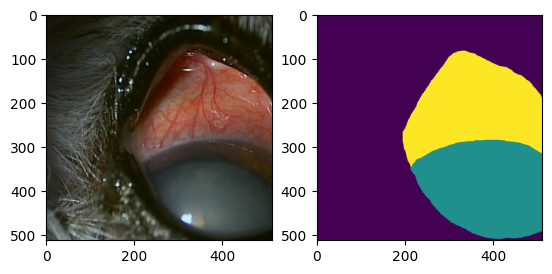

In [2]:
ds = ConjDataset(mode='val', normalization=False)

for i in range(5):
    image, label = ds[i]

    plt.subplot(1,2,1)
    plt.imshow(Image.fromarray((image.numpy().transpose(1, 2, 0)).astype(np.uint8)))
    plt.subplot(1,2,2)
    plt.imshow(label.numpy())
    plt.show()

In [3]:
from torch.utils.data import DataLoader
from pydantic import Field, BaseModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from monai.networks.nets import UNet

pl.seed_everything(0)
torch.set_float32_matmul_precision('medium')

Seed set to 0


In [ ]:
from ketsu.main import ConjConfig, ConjModule


class TrainArgs(ConjConfig):
    batch_size: int = Field(10, s='-B')
    num_workers: int = 4
    checkpoint_dir: str = 'checkpoints'
    experiment_name: str = Field('{arch_name}', l='--exp')
    size: int = 512


a = TrainArgs(arch_name='unet16')

checkpoint_dir = os.path.join(
    a.checkpoint_dir,
    a.experiment_name.format(**a.model_dump())
)

os.makedirs(checkpoint_dir, exist_ok=True)

train_ds = ConjDataset(mode='train', augmentation=True)
val_ds = ConjDataset(mode='val', augmentation=False)
train_loader = DataLoader(train_ds, a.batch_size, num_workers=a.num_workers, shuffle=True)
val_loader = DataLoader(val_ds, a.batch_size, num_workers=a.num_workers)

checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath=checkpoint_dir,
    filename='{epoch:02d}-{val_loss:.3f}',
    save_top_k=1,
    mode='min',
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='gpu',
    callbacks=[checkpoint, early_stopping],
    log_every_n_steps=1,
    logger=True,
)

config = ConjConfig(**a.model_dump())
print('config', config)
module = ConjModule(config)
trainer.fit(module, train_loader, val_loader)

print(f'\nBest model path: {checkpoint.best_model_path}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


config num_classes=3 arch_name='unet16' lr=0.001


/home/ken/src/github.com/endaaman/ketsu/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ken/src/github.com/endaaman/ketsu/checkpoints/unet16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | unet       | UNet16                 | 32.2 M | train
1 | criterion  | CrossEntropyLoss       | 0      | train
2 | metric_acc | MulticlassAccuracy     | 0      | train
3 | metric_jac | MulticlassJaccardIndex | 0      | train
--------------------------------------------------------------
32.2 M    Trainable params
0         Non-trainable params
32.2 M    Total params
128.866   Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s, v_num=43, lr=0.001]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s, v_num=43, lr=0.001, val_loss=1.300, train_loss=0.976]

Metric val_loss improved. New best score: 1.298


Epoch 1: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=1.300, train_loss=0.976]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=15.10, train_loss=0.599]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.33it/s, v_num=43, lr=0.001, val_loss=4.730, train_loss=0.386]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=3.280

Metric val_loss improved by 0.654 >= min_delta = 0.0. New best score: 0.643


Epoch 7: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.643, train_loss=0.171]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.963, train_loss=0.191]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=1.110, train_loss=0.187]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s, v_num=43, lr=0.001, val_loss=0.568

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.568


Epoch 10: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.33it/s, v_num=43, lr=0.001, val_loss=0.568, train_loss=0.163]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s, v_num=43, lr=0.001, val_loss=0.515, train_loss=0.134]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.515


Epoch 11: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.515, train_loss=0.134]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s, v_num=43, lr=0.001, val_loss=0.511, train_loss=0.154]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.511


Epoch 12: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.511, train_loss=0.154]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.519, train_loss=0.114]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.520, train_loss=0.108]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.550

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.462


Epoch 16: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.462, train_loss=0.114]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s, v_num=43, lr=0.001, val_loss=0.336, train_loss=0.120]

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 0.336


Epoch 17: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s, v_num=43, lr=0.001, val_loss=0.336, train_loss=0.120]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.508, train_loss=0.111]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.368, train_loss=0.120]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s, v_num=43, lr=0.001, val_loss=0.550

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.330


Epoch 23: 100%|██████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.330, train_loss=0.0851]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.356, train_loss=0.0798]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s, v_num=43, lr=0.001, val_loss=0.314, train_loss=0.0975]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.314


Epoch 25: 100%|██████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s, v_num=43, lr=0.001, val_loss=0.314, train_loss=0.0975]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|███████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s, v_num=43, lr=0.001, val_loss=0.408, train_loss=0.106]
idation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 27:   0%|                                                      | 0/4 [00:00<?, ?it/s, v_num=43, lr=0.001, val_loss=0.487, train_loss=0.0815]

In [ ]:
test_ds = ConjDataset(mode='val', size=640, augmentation=False)
test_loader = DataLoader(test_ds, a.batch_size, num_workers=a.num_workers)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
)

print(trainer.test(module, test_loader))